# Actual Value of information using standard reward formulation

Average reward: -0.044585987261146494
Cumulative MSE: 0.00012416140588729265
Total Transmissions (Oracle): 45
Total Transmissions (Push): 157


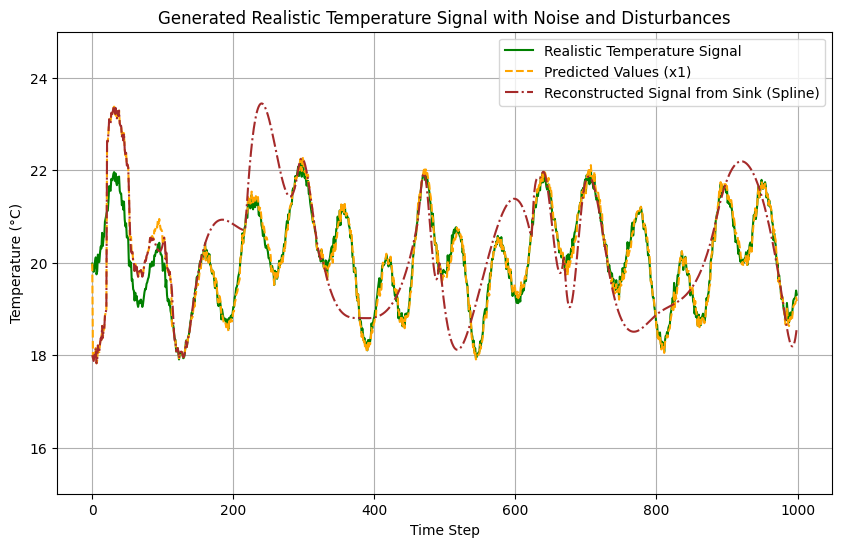

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0.5
    cumulative_mse = 0
    push_transmission_count = 0
    oracle_transmission_count = 0
    last_update_time = 0
    #voi_mse_list = []
    reward = 0
    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]
    predicted_values = [z_temp[0]]  # Initialize with the first value (for t=0)
    oracle_transmission_times = []  # To store the times when oracle transmits
    push_transmission_times = []
    predicted_at_transmissions = []  # To store predicted values at oracle transmission points
    transmitted_values = []  # To store transmitted values (x1 and x2)

    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)
        #mse = mse_between_estimate_and_true(x1, measured_value)
        # Calculate the predicted value using the rate of change and time elapsed
        #predicted_value = last_state_value + (last_rate_of_change * delta_t)

    
        # Oracle decision (transmit only if VoI > threshold)
        #if np.abs( xmeasured_value - oracle_last_transmitted_value) > threshold:
        delta = t - last_update_time
        #if np.abs(x2*delta) > threshold:
        if np.abs( x1 - last_state_value ) > threshold:
              # Update the last transmitted value
             # Store the time of oracle transmission
            predicted_at_transmissions.append(x1)  # Store the predicted value at this transmission point
            transmitted_values.append((t, x1, x2))  # Store both x1 and x2 at the transmission points
            push_transmission_count += 1
            push_transmission_times.append(t) 
            last_update_time = t
        
        predicted_values.append(x1)
        if np.abs( measured_value - oracle_last_transmitted_value) > threshold:
            oracle_last_transmitted_value = measured_value
            oracle_transmission_times.append(t)
            oracle_transmission_count += 1
            #oracle_last_transmitted_value = measured_value
            if np.abs( x1 - last_state_value ) > threshold:
            #if np.abs(x2*delta) > threshold:
                reward += 1
            else:
                reward -= 1
            
        # Update the estimated state
            last_state_value = x1
            last_rate_of_change = x2
    mse = mse_between_estimate_and_true(x1, measured_value)
    cumulative_mse += mse
    cumulative_mse = cumulative_mse / push_transmission_count
    ave_reward = reward/push_transmission_count

    return ave_reward ,cumulative_mse, push_transmission_count, oracle_transmission_count,predicted_values, oracle_transmission_times,push_transmission_times, predicted_at_transmissions, transmitted_values


# Generate realistic temperature signal with dynamic amplitude, random phase shifts, and irregular periods
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)

    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly amplitude variation
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period

    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic


# Parameters for the signal
total_time = 1000  # Total simulation time (in hours or time units)
time_resolution = 1  # Time step resolution (in hours or time units)
T_avg = 20  # Average temperature
T_period = 100  # Period of the temperature cycle (daily cycle, 24 hours)
noise_amplitude = 0.1  # Amplitude of the noise
disturbance_probability = 0  # Probability of a disturbance occurring at each time step

# Generate the realistic temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Parameters for the push-based system
threshold = 1.0  # Threshold for VoI
beta_1 = 0.9  # dEWMA beta_1
beta_2 = 0.9  # dEWMA beta_2
delta_t = 1  # Time step for the rate of change

# Run the experiment for the push-based system with VoI calculation
ave_reward, cumulative_mse, push_transmission_count, oracle_transmission_count,predicted_values, oracle_transmission_times, push_transmission_times, predicted_at_transmissions, transmitted_values = push_based_system_voi(T_realistic, total_time, threshold, beta_1, beta_2, delta_t)

# Output Results
print(f"Average reward: {ave_reward}")
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {oracle_transmission_count}")
print(f"Total Transmissions (Push): {push_transmission_count}")


# Plot the generated temperature signal with noise and disturbances
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Realistic Temperature Signal", color='green')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Generated Realistic Temperature Signal with Noise and Disturbances")
plt.ylim(15, 25)


# Plot the predicted values (based on x1 from dEWMA)
plt.plot(t, predicted_values, label="Predicted Values (x1)", color='orange', linestyle='--')


# Reconstruct the temperature path using spline interpolation from transmitted data
transmitted_times, transmitted_x1_values, transmitted_x2_values = zip(*transmitted_values)

# Spline fitting: Use cubic spline interpolation to reconstruct the signal
spline_reconstruction = CubicSpline(transmitted_times, transmitted_x1_values, bc_type='natural')
reconstructed_signal = spline_reconstruction(t)

# Plot the reconstructed signal
plt.plot(t, reconstructed_signal, label="Reconstructed Signal from Sink (Spline)", color='brown', linestyle='-.')

plt.legend()
plt.grid(True)
plt.show()


In [133]:
import numpy as np
import random

# Helper function to update state using dEWMA
# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0.5
    cumulative_mse = 0
    push_transmission_count = 0
    oracle_transmission_count = 0
    last_update_time = 0
    #voi_mse_list = []
    reward = 0
    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]
    predicted_values = [z_temp[0]]  # Initialize with the first value (for t=0)
    oracle_transmission_times = []  # To store the times when oracle transmits
    push_transmission_times = []
    predicted_at_transmissions = []  # To store predicted values at oracle transmission points
    transmitted_values = []  # To store transmitted values (x1 and x2)

    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)
        #mse = mse_between_estimate_and_true(x1, measured_value)
        # Calculate the predicted value using the rate of change and time elapsed
        #predicted_value = last_state_value + (last_rate_of_change * delta_t)

    
        # Oracle decision (transmit only if VoI > threshold)
        #if np.abs( xmeasured_value - oracle_last_transmitted_value) > threshold:
        delta = t - last_update_time
        if np.abs(x2*delta) > threshold:
        #if np.abs( x1 - last_state_value ) > threshold:
              # Update the last transmitted value
             # Store the time of oracle transmission
            predicted_at_transmissions.append(x1)  # Store the predicted value at this transmission point
            transmitted_values.append((t, x1, x2))  # Store both x1 and x2 at the transmission points
            push_transmission_count += 1
            push_transmission_times.append(t) 
            last_update_time = t
        
        predicted_values.append(x1)
        if np.abs( measured_value - oracle_last_transmitted_value) > threshold:
            oracle_last_transmitted_value = measured_value
            oracle_transmission_times.append(t)
            oracle_transmission_count += 1
            #oracle_last_transmitted_value = measured_value
            if np.abs( x1 - last_state_value ) > threshold:
            #if np.abs(x2*delta) > threshold:
                reward += 1
            else:
                reward -= 1
            
        # Update the estimated state
            last_state_value = x1
            last_rate_of_change = x2
    mse = mse_between_estimate_and_true(x1, measured_value)
    cumulative_mse += mse
    cumulative_mse = cumulative_mse / push_transmission_count
    ave_reward = reward/push_transmission_count
    push_packet_percentage = (push_transmission_count / oracle_transmission_count) * 100 if oracle_transmission_count > 0 else 0

    return ave_reward, cumulative_mse, push_packet_percentage, push_transmission_count, oracle_transmission_count


# Generate realistic temperature signal with dynamic amplitude, random phase shifts, and irregular periods
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)

    #amplitude_variation = 5 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly amplitude variation
    amplitude_variation = 5
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period

    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic


# Parameters for the simulation
total_time = 5000
time_resolution = 1
T_avg = 20
T_period = 500
noise_amplitude = 0.1
disturbance_probability = 0
beta_1 = 0.9
beta_2 = 0.1
delta_t = 1
threshold_values = [0.2, 0.4, 0.6, 0.8, 1.0]

t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Run for different epsilon values
for threshold in threshold_values:
    ave_reward, cumulative_mse, push_packet_percentage, push_transmission_count, oracle_transmission_count = push_based_system_voi(T_realistic, total_time, threshold , beta_1, beta_2, delta_t)
    print(f"Threshold: {threshold }, Average Reward: {ave_reward:.4f}, Cumulative MSE: {cumulative_mse:.4f}, Push Packet %: {push_packet_percentage:.2f}, Oracle Transmissions: {oracle_transmission_count}, Push Transmissions: {push_transmission_count}")



Threshold: 0.2, Average Reward: 0.2723, Cumulative MSE: 0.0000, Push Packet %: 231.01, Oracle Transmissions: 1132, Push Transmissions: 2615
Threshold: 0.4, Average Reward: 0.1754, Cumulative MSE: 0.0000, Push Packet %: 518.91, Oracle Transmissions: 423, Push Transmissions: 2195
Threshold: 0.6, Average Reward: 0.1257, Cumulative MSE: 0.0000, Push Packet %: 710.64, Oracle Transmissions: 282, Push Transmissions: 2004
Threshold: 0.8, Average Reward: 0.1048, Cumulative MSE: 0.0000, Push Packet %: 803.70, Oracle Transmissions: 216, Push Transmissions: 1736
Threshold: 1.0, Average Reward: 0.0889, Cumulative MSE: 0.0000, Push Packet %: 871.60, Oracle Transmissions: 169, Push Transmissions: 1473


# Pull based VoI

average reward:-3.5
Cumulative MSE: 8.104875477363196
Total Transmissions (Oracle): 321
Total Transmissions (Pull): 86


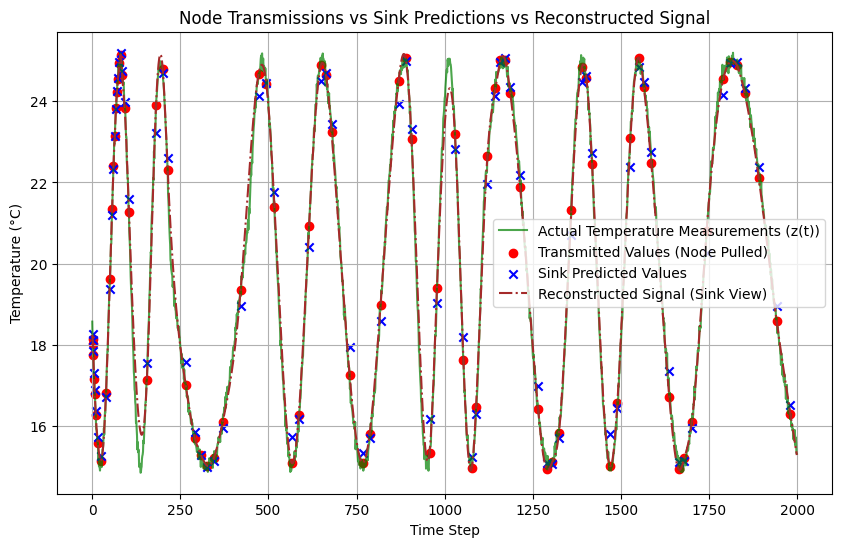

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Helper function to update sink state using dEWMA
def update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_sink_value + last_sink_rate * delta_t)
    x2 = beta_2 * (x1 - last_sink_value) / delta_t + (1 - beta_2) * last_sink_rate
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the pull-based system (sink-side processing)
def pull_based_system_sink_dewma(z_temp, time_steps, threshold, beta_1, beta_2):
    transmission_times = []  # Time steps when the node transmits
    transmitted_values = []  # (Time, z(t))
    sink_predictions = []  # (Time, Predicted x1 at pull time)
    reconstructed_values = np.zeros(time_steps)  # Placeholder for reconstruction

    # **Initialize sink state with first measurement**
    last_sink_value = z_temp[0]  # First received measurement
    last_sink_rate = 1  # Initial rate of change is set to 1 (forces system to start updating)
    last_transmission_time = 0  # When last z(t) was received
    last_received_measurement = z_temp[0]
    reward = 0
    oracle_last_transmitted_value = 0
    oracle_transmission_times = []
    oracle_transmission_count = 0
    pull_transmission_count = 0
    cumulative_mse = 0

    for t in range(1, time_steps):
        delta_t = t - last_transmission_time  # Time since last transmission

        # **Sink Predicts Node's State using last received measurement and last sink rate**
        sink_predicted_value = last_received_measurement + last_sink_rate * delta_t  
        measured_value = z_temp[t]
        #x1, x2 = update_sink_state_dewma(sink_predicted_value, last_sink_value, last_sink_rate, 1, beta_1, beta_2)
        #sink_predicted_value = x1 + x2 * delta_t
        #x2 = last_sink_rate
       

        if abs(sink_predicted_value - last_received_measurement) > threshold or  min_rate_of_change * delta_t > threshold:  
        # **Threshold Check**: Pull the node if the predicted change exceeds the threshold
        #if (abs(last_sink_rate) * delta_t > threshold) or  min_rate_of_change * delta_t > threshold:
            # The sink pulls the node and receives a new measurement z(t)
            measured_value = z_temp[t]

            # **Sink updates itself using dEWMA**
            x1, x2 = update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2)

            # Store transmission times and values
            transmission_times.append(t)
            transmitted_values.append((t, measured_value))
            pull_transmission_count += 1

            # Store sink's predicted value at the time of pull
            #sink_predictions.append((t, sink_predicted_value))
            sink_predictions.append((t, x1))
            # Capture the push-based system's estimated value at this oracle transmission point
            #mse = mse_between_estimate_and_true(x1, measured_value)
            #cumulative_mse += mse

            # Update the last received values
            last_received_measurement = measured_value
            last_sink_value = x1
            last_sink_rate = x2
            last_transmission_time = t  # Update transmission time
        
        if np.abs( measured_value - oracle_last_transmitted_value) > threshold:
            oracle_last_transmitted_value = measured_value
            oracle_transmission_times.append(t)
            oracle_transmission_count += 1

            #if abs(sink_predicted_value - last_received_measurement) > threshold or  min_rate_of_change * delta_t > threshold:
            if (abs(last_sink_rate) * delta_t > threshold)  or  min_rate_of_change * delta_t > threshold:

                reward += 1 
            else: 
                reward -= 1

        # **Reconstruct Signal**
        predicted = last_sink_value + last_sink_rate * delta_t
        reconstructed_values[t] = last_sink_value + last_sink_rate * delta_t
        mse = mse_between_estimate_and_true(predicted, measured_value)
        cumulative_mse += mse
    cumulative_mse = cumulative_mse / time_steps
    ave_reward = reward/pull_transmission_count

    return ave_reward,cumulative_mse, pull_transmission_count , oracle_transmission_count, transmission_times, transmitted_values, sink_predictions, reconstructed_values

# Generate a realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)
    #amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))
    amplitude_variation = 5
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])
    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic

# Simulation Parameters
total_time = 2000  
time_resolution = 1  
T_avg = 20  
T_period = 200  
noise_amplitude = 0.1 
disturbance_probability = 0 
 
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# System Parameters
threshold = 0.5
beta_1 = 0.9
beta_2 = 0.2
min_rate_of_change = 0.01
# Run the pull-based system simulation (sink-side processing)
ave_reward,cumulative_mse, pull_transmission_count , oracle_transmission_count,transmission_times, transmitted_values, sink_predictions, reconstructed_values = pull_based_system_sink_dewma(
    T_realistic, total_time, threshold, beta_1, beta_2
)

# Extract values for plotting
if transmitted_values:
    transmit_times, transmit_values = zip(*transmitted_values)
else:
    transmit_times, transmit_values = [],[]

if sink_predictions:
    sink_pred_times, sink_pred_values = zip(*sink_predictions)
else:
    sink_pred_times, sink_pred_values = [],[]

# **Check if enough points exist for a spline fit**
if len(transmit_times) > 1:
    spline = CubicSpline(transmit_times, transmit_values, bc_type='natural')
    smooth_reconstructed_values = spline(t)
else:
    smooth_reconstructed_values = np.interp(t, transmit_times, transmit_values) if transmit_times else np.zeros_like(t)

# Output Results
print(f"average reward:{ave_reward}")
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {oracle_transmission_count}")
print(f"Total Transmissions (Pull): {pull_transmission_count}")

# **Plot the Results**
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Actual Temperature Measurements (z(t))", color='green', linestyle='-', alpha=0.7)

# Highlight transmitted values
plt.scatter(transmit_times, transmit_values, color='red', label="Transmitted Values (Node Pulled)")

# Highlight sink predictions at pull times
plt.scatter(sink_pred_times, sink_pred_values, color='blue', marker='x', label="Sink Predicted Values")

# Plot reconstructed values
plt.plot(t, smooth_reconstructed_values, label="Reconstructed Signal (Sink View)", color='brown', linestyle='-.')

plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Node Transmissions vs Sink Predictions vs Reconstructed Signal")
plt.legend()
plt.grid(True)
plt.show()


In [136]:
import numpy as np
import random

# Helper function to update sink state using dEWMA
def update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_sink_value + last_sink_rate * delta_t)
    x2 = beta_2 * (x1 - last_sink_value) / delta_t + (1 - beta_2) * last_sink_rate
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the pull-based system (sink-side processing)
def pull_based_system_sink_dewma(z_temp, time_steps, threshold, beta_1, beta_2):
    transmission_times = []  # Time steps when the node transmits
    transmitted_values = []  # (Time, z(t))
    sink_predictions = []  # (Time, Predicted x1 at pull time)
    reconstructed_values = np.zeros(time_steps)  # Placeholder for reconstruction


    # **Initialize sink state with first measurement**
    last_sink_value = z_temp[0]  # First received measurement
    last_sink_rate = 0.5  # Initial rate of change is set to 1 (forces system to start updating)
    last_transmission_time = 0  # When last z(t) was received
    last_received_measurement = z_temp[0]
    reward = 0
    oracle_last_transmitted_value = 0
    oracle_transmission_count = 0
    pull_transmission_count = 0
    cumulative_mse = 0
    oracle_transmission_times = []


    for t in range(1, time_steps):
        delta_t = t - last_transmission_time  # Time since last transmission

        # **Sink Predicts Node's State using last received measurement and last sink rate**
        sink_predicted_value = last_received_measurement + last_sink_rate * delta_t  
        measured_value = z_temp[t]
        #x1, x2 = update_sink_state_dewma(sink_predicted_value, last_sink_value, last_sink_rate, 1, beta_1, beta_2)
        #sink_predicted_value = x1 + x2 * delta_t
        #x2 = last_sink_rate
       

        if abs(sink_predicted_value - last_received_measurement) > threshold or  min_rate_of_change * delta_t > threshold:  
        # **Threshold Check**: Pull the node if the predicted change exceeds the threshold
        #if (abs(last_sink_rate) * delta_t > threshold) or  min_rate_of_change * delta_t > threshold:
            # The sink pulls the node and receives a new measurement z(t)
            measured_value = z_temp[t]

            # **Sink updates itself using dEWMA**
            x1, x2 = update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2)

            # Store transmission times and values
            transmission_times.append(t)
            transmitted_values.append((t, measured_value))
            pull_transmission_count += 1
            

            # Store sink's predicted value at the time of pull
            sink_predictions.append((t, sink_predicted_value))
            #sink_predictions.append((t, x1))
            # Capture the push-based system's estimated value at this oracle transmission point
            #mse = mse_between_estimate_and_true(x1, measured_value)
            #cumulative_mse += mse

            # Update the last received values
            last_received_measurement = measured_value
            last_sink_value = x1
            last_sink_rate = x2
            last_transmission_time = t  # Update transmission time
        
        if np.abs( measured_value - oracle_last_transmitted_value) > threshold:
            oracle_last_transmitted_value = measured_value
            oracle_transmission_times.append(t)
            oracle_transmission_count += 1

            #if abs(sink_predicted_value - last_received_measurement) > threshold or  min_rate_of_change * delta_t > threshold:
            if (abs(last_sink_rate) * delta_t > threshold)  or  min_rate_of_change * delta_t > threshold:

                reward += 1 
            else: 
                reward -= 1

        # **Reconstruct Signal**
        predicted = last_sink_value + last_sink_rate * delta_t
        reconstructed_values[t] = last_sink_value + last_sink_rate * delta_t
        mse = mse_between_estimate_and_true(predicted, measured_value)
        cumulative_mse += mse
    cumulative_mse /= time_steps
    ave_reward = reward / pull_transmission_count if pull_transmission_count > 0 else 0
    pull_packet_percentage = (pull_transmission_count / oracle_transmission_count) * 100 if oracle_transmission_count > 0 else 0

    return ave_reward, cumulative_mse, pull_packet_percentage, pull_transmission_count, oracle_transmission_count

# Generate a realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)
    #amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))
    amplitude_variation = 5
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])
    return t, T_dynamic + noise + disturbances

# Simulation Parameters
total_time = 20000
time_resolution = 1
T_avg = 20
T_period = 2000
noise_amplitude = 0.1
disturbance_probability = 0
beta_1 = 0.9
beta_2 = 0.9
threshold_values = [0.2, 0.4, 0.6, 0.8, 1.0]

t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Run for different threshold values
for threshold in threshold_values:
    ave_reward, cumulative_mse, pull_packet_percentage, pull_transmission_count, oracle_transmission_count = pull_based_system_sink_dewma(T_realistic, total_time, threshold, beta_1, beta_2)
    print(f"Threshold: {threshold}, Average Reward: {ave_reward:.4f}, Cumulative MSE: {cumulative_mse:.4f}, Pull Packet %: {pull_packet_percentage:.2f}, Oracle Transmissions: {oracle_transmission_count}, Pull Transmissions: {pull_transmission_count}")



Threshold: 0.2, Average Reward: -2.6344, Cumulative MSE: 0.0321, Pull Packet %: 34.38, Oracle Transmissions: 3453, Pull Transmissions: 1187
Threshold: 0.4, Average Reward: -0.8416, Cumulative MSE: 0.0371, Pull Packet %: 113.06, Oracle Transmissions: 536, Pull Transmissions: 606
Threshold: 0.6, Average Reward: -0.7299, Cumulative MSE: 0.0442, Pull Packet %: 132.58, Oracle Transmissions: 310, Pull Transmissions: 411
Threshold: 0.8, Average Reward: -0.7065, Cumulative MSE: 0.0662, Pull Packet %: 134.20, Oracle Transmissions: 231, Pull Transmissions: 310
Threshold: 1.0, Average Reward: -0.7097, Cumulative MSE: 0.1124, Pull Packet %: 136.26, Oracle Transmissions: 182, Pull Transmissions: 248


# Mean squared error calculation

Cumulative reward: 14
Cumulative MSE: 3.3550085004807255e-06
Total Transmissions (Oracle): 92
Total Transmissions (Push): 98


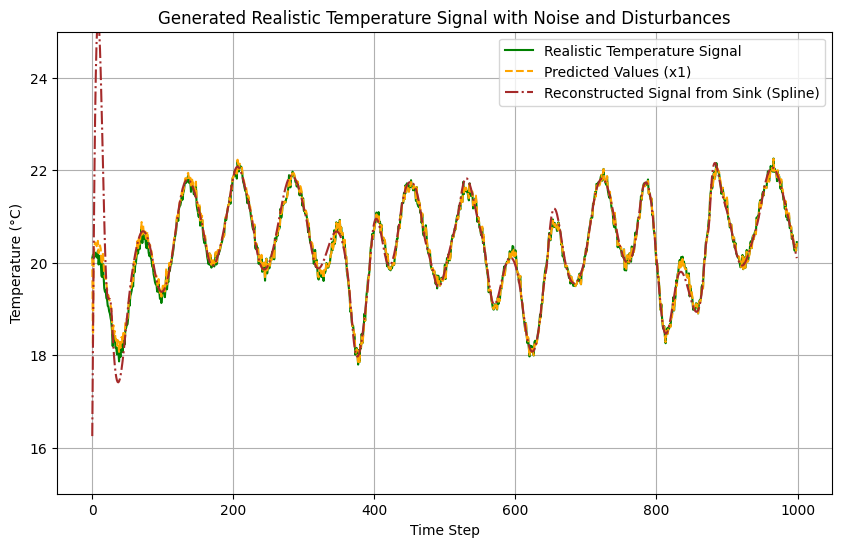

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0.5
    cumulative_mse = 0
    push_transmission_count = 0
    oracle_transmission_count = 0
    last_update_time = 0
    #voi_mse_list = []
    reward = 0
    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]
    predicted_values = [z_temp[0]]  # Initialize with the first value (for t=0)
    oracle_transmission_times = []  # To store the times when oracle transmits
    push_transmission_times = []
    predicted_at_transmissions = []  # To store predicted values at oracle transmission points
    transmitted_values = []  # To store transmitted values (x1 and x2)

    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)
        #mse = mse_between_estimate_and_true(x1, measured_value)
        # Calculate the predicted value using the rate of change and time elapsed
        #predicted_value = last_state_value + (last_rate_of_change * delta_t)
        predicted_values.append(x1)
        if np.abs( measured_value - oracle_last_transmitted_value) > threshold:
            oracle_last_transmitted_value = measured_value
            oracle_transmission_times.append(t)
            oracle_transmission_count += 1
            #oracle_last_transmitted_value = measured_value
            if np.abs(x2*delta) > threshold:
                reward += 1
            else:
                reward -= 1
            
    
        # Oracle decision (transmit only if VoI > threshold)
        #if np.abs( xmeasured_value - oracle_last_transmitted_value) > threshold:
        delta = t - last_update_time
        #if np.abs(x2*delta) > threshold:
        if np.abs( x1 - last_state_value ) > threshold:
              # Update the last transmitted value
             # Store the time of oracle transmission
            predicted_at_transmissions.append(x1)  # Store the predicted value at this transmission point
            transmitted_values.append((t, x1, x2))  # Store both x1 and x2 at the transmission points
            push_transmission_count += 1
            push_transmission_times.append(t) 
            last_update_time = t
        
        
        # Update the estimated state
            last_state_value = x1
            last_rate_of_change = x2
    mse = mse_between_estimate_and_true(x1, measured_value)
    cumulative_mse += mse
    cumulative_mse = cumulative_mse / push_transmission_count

    return reward,cumulative_mse, push_transmission_count, oracle_transmission_count,predicted_values, oracle_transmission_times,push_transmission_times, predicted_at_transmissions, transmitted_values


# Generate realistic temperature signal with dynamic amplitude, random phase shifts, and irregular periods
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)

    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly amplitude variation
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period

    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic


# Parameters for the signal
total_time = 1000  # Total simulation time (in hours or time units)
time_resolution = 1  # Time step resolution (in hours or time units)
T_avg = 20  # Average temperature
T_period = 100  # Period of the temperature cycle (daily cycle, 24 hours)
noise_amplitude = 0.1  # Amplitude of the noise
disturbance_probability = 0  # Probability of a disturbance occurring at each time step

# Generate the realistic temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Parameters for the push-based system
threshold = 0.5  # Threshold for VoI
beta_1 = 0.9  # dEWMA beta_1
beta_2 = 0.1  # dEWMA beta_2
delta_t = 1  # Time step for the rate of change

# Run the experiment for the push-based system with VoI calculation
reward, cumulative_mse, push_transmission_count, oracle_transmission_count,predicted_values, oracle_transmission_times, push_transmission_times, predicted_at_transmissions, transmitted_values = push_based_system_voi(T_realistic, total_time, threshold, beta_1, beta_2, delta_t)

# Output Results
print(f"Cumulative reward: {reward}")
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {oracle_transmission_count}")
print(f"Total Transmissions (Push): {push_transmission_count}")


# Plot the generated temperature signal with noise and disturbances
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Realistic Temperature Signal", color='green')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Generated Realistic Temperature Signal with Noise and Disturbances")
plt.ylim(15, 25)


# Plot the predicted values (based on x1 from dEWMA)
plt.plot(t, predicted_values, label="Predicted Values (x1)", color='orange', linestyle='--')


# Reconstruct the temperature path using spline interpolation from transmitted data
transmitted_times, transmitted_x1_values, transmitted_x2_values = zip(*transmitted_values)

# Spline fitting: Use cubic spline interpolation to reconstruct the signal
spline_reconstruction = CubicSpline(transmitted_times, transmitted_x1_values, bc_type='natural')
reconstructed_signal = spline_reconstruction(t)

# Plot the reconstructed signal
plt.plot(t, reconstructed_signal, label="Reconstructed Signal from Sink (Spline)", color='brown', linestyle='-.')

plt.legend()
plt.grid(True)
plt.show()


# Pulling Section

Cumulative MSE: 0.12417059062025894
Total Transmissions (Oracle): 565
Total Transmissions (Pull): 426


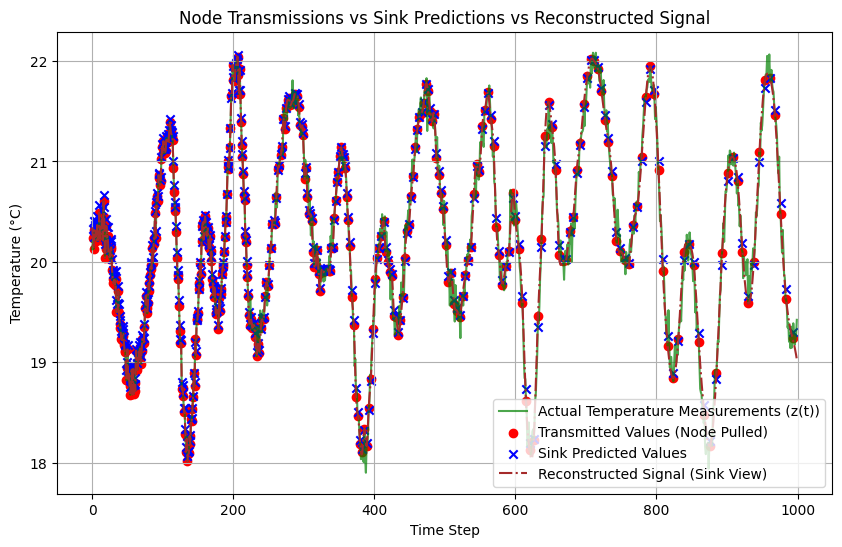

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Helper function to update sink state using dEWMA
def update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_sink_value + last_sink_rate * delta_t)
    x2 = beta_2 * (x1 - last_sink_value) / delta_t + (1 - beta_2) * last_sink_rate
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the pull-based system (sink-side processing)
def pull_based_system_sink_dewma(z_temp, time_steps, threshold, beta_1, beta_2):
    transmission_times = []  # Time steps when the node transmits
    transmitted_values = []  # (Time, z(t))
    sink_predictions = []  # (Time, Predicted x1 at pull time)
    reconstructed_values = np.zeros(time_steps)  # Placeholder for reconstruction

    # **Initialize sink state with first measurement**
    last_sink_value = z_temp[0]  # First received measurement
    last_sink_rate = 1  # Initial rate of change is set to 1 (forces system to start updating)
    last_transmission_time = 0  # When last z(t) was received
    last_received_measurement = z_temp[0]
    oracle_last_transmitted_value = 0
    oracle_transmission_count = 0
    pull_transmission_count = 0
    cumulative_mse = 0

    for t in range(1, time_steps):
        delta_t = t - last_transmission_time  # Time since last transmission

        # **Sink Predicts Node's State using last received measurement and last sink rate**
        #sink_predicted_value = last_received_measurement + last_sink_rate * delta_t  
        measured_value = z_temp[t]
        #x1, x2 = update_sink_state_dewma(sink_predicted_value, last_sink_value, last_sink_rate, 1, beta_1, beta_2)
        #sink_predicted_value = x1 + x2 * delta_t
        #x2 = last_sink_rate
        if np.abs( measured_value - oracle_last_transmitted_value) > threshold:
            oracle_last_transmitted_value = measured_value
            oracle_transmission_times.append(t)
            oracle_transmission_count += 1

            
        # **Threshold Check**: Pull the node if the predicted change exceeds the threshold
        if (abs(last_sink_rate) * delta_t > threshold) or  min_rate_of_change * delta_t > threshold:
            # The sink pulls the node and receives a new measurement z(t)
            measured_value = z_temp[t]

            # **Sink updates itself using dEWMA**
            x1, x2 = update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2)

            # Store transmission times and values
            transmission_times.append(t)
            transmitted_values.append((t, measured_value))
            pull_transmission_count += 1

            # Store sink's predicted value at the time of pull
            #sink_predictions.append((t, sink_predicted_value))
            sink_predictions.append((t, x1))
            # Capture the push-based system's estimated value at this oracle transmission point
            #mse = mse_between_estimate_and_true(x1, measured_value)
            #cumulative_mse += mse

            # Update the last received values
            last_received_measurement = measured_value
            last_sink_value = x1
            last_sink_rate = x2
            last_transmission_time = t  # Update transmission time

        # **Reconstruct Signal**
        predicted = last_sink_value + last_sink_rate * delta_t
        reconstructed_values[t] = last_sink_value + last_sink_rate * delta_t
        mse = mse_between_estimate_and_true(predicted, measured_value)
        cumulative_mse += mse
    cumulative_mse = cumulative_mse / time_steps

    return cumulative_mse, pull_transmission_count , oracle_transmission_count, transmission_times, transmitted_values, sink_predictions, reconstructed_values

# Generate a realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)
    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])
    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic

# Simulation Parameters
total_time = 1000  
time_resolution = 1  
T_avg = 20  
T_period = 100  
noise_amplitude = 0.1 
disturbance_probability = 0 
 

t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# System Parameters
threshold = 0.1 
beta_1 = 0.9
beta_2 = 0.01
min_rate_of_change = 0.000
# Run the pull-based system simulation (sink-side processing)
cumulative_mse, pull_transmission_count , oracle_transmission_count,transmission_times, transmitted_values, sink_predictions, reconstructed_values = pull_based_system_sink_dewma(
    T_realistic, total_time, threshold, beta_1, beta_2
)

# Extract values for plotting
if transmitted_values:
    transmit_times, transmit_values = zip(*transmitted_values)
else:
    transmit_times, transmit_values = [], []

if sink_predictions:
    sink_pred_times, sink_pred_values = zip(*sink_predictions)
else:
    sink_pred_times, sink_pred_values = [], []

# **Check if enough points exist for a spline fit**
if len(transmit_times) > 1:
    spline = CubicSpline(transmit_times, transmit_values, bc_type='natural')
    smooth_reconstructed_values = spline(t)
else:
    smooth_reconstructed_values = np.interp(t, transmit_times, transmit_values) if transmit_times else np.zeros_like(t)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {oracle_transmission_count}")
print(f"Total Transmissions (Pull): {pull_transmission_count}")

# **Plot the Results**
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Actual Temperature Measurements (z(t))", color='green', linestyle='-', alpha=0.7)

# Highlight transmitted values
plt.scatter(transmit_times, transmit_values, color='red', label="Transmitted Values (Node Pulled)")

# Highlight sink predictions at pull times
plt.scatter(sink_pred_times, sink_pred_values, color='blue', marker='x', label="Sink Predicted Values")

# Plot reconstructed values
plt.plot(t, smooth_reconstructed_values, label="Reconstructed Signal (Sink View)", color='brown', linestyle='-.')

plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Node Transmissions vs Sink Predictions vs Reconstructed Signal")
plt.legend()
plt.grid(True)
plt.show()


# Varying number of pulled nodes

In [2]:
import numpy as np
import random

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate N nodes with M available channels
def multi_node_push_based_system(N, M, time_steps, threshold, beta_1, beta_2, delta_t, temperature_signals):
    nodes = [{'last_state_value': 0, 'last_rate_of_change': 0.5, 'last_update_time': 0} for _ in range(N)]
    transmission_attempts = {m: [] for m in range(M)}  # Track channel collisions
    total_transmissions = 0
    failed_transmissions = 0
    
    for t in range(1, time_steps):
        successful_transmissions = set()
        
        for node_id in range(N):
            measured_value = temperature_signals[node_id][t]
            node = nodes[node_id]
            
            x1, x2 = update_node_state_dewma(measured_value, node['last_state_value'], node['last_rate_of_change'], delta_t, beta_1, beta_2)
            delta = t - node['last_update_time']
            
            if np.abs(x2 * delta) > threshold:
                chosen_channel = random.randint(0, M - 1)
                
                if chosen_channel in successful_transmissions:
                    failed_transmissions += 1  # Collision occurred
                else:
                    successful_transmissions.add(chosen_channel)
                    total_transmissions += 1
                    node['last_update_time'] = t
                    node['last_state_value'] = x1
                    node['last_rate_of_change'] = x2
    
    return total_transmissions, failed_transmissions

# Generate realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)
    T_signals = []
    
    for _ in range(N):
        amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))
        random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
        irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
        omega = 2 * np.pi / irregular_period

        T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
        noise = np.random.normal(0, noise_amplitude, len(t))
        disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

        T_signals.append(T_dynamic + noise + disturbances)
    
    return T_signals

# Simulation parameters
N = 50  # Number of nodes
M = 10   # Number of channels
total_time = 1000  # Total simulation time
time_resolution = 1
T_avg = 20
T_period = 100
noise_amplitude = 0.1
disturbance_probability = 0
threshold = 0.5
beta_1 = 0.9
beta_2 = 0.1
delta_t = 1

temperature_signals = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

total_transmissions, failed_transmissions = multi_node_push_based_system(N, M, total_time, threshold, beta_1, beta_2, delta_t, temperature_signals)

print(f"Total successful transmissions: {total_transmissions}")
print(f"Total failed transmissions due to collisions: {failed_transmissions}")


Total successful transmissions: 6630
Total failed transmissions due to collisions: 7147


In [3]:
import numpy as np
import pandas as pd
import random

# Helper function to update sink state using dEWMA
def update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_sink_value + last_sink_rate * delta_t)
    x2 = beta_2 * (x1 - last_sink_value) / delta_t + (1 - beta_2) * last_sink_rate
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the pull-based system using a dataframe of N sensors
def pull_based_system_from_dataframe(df, time_steps, M, threshold, beta_1, beta_2):
    N = df.shape[1]  # Number of sensors
    last_sink_values = np.zeros(N)
    last_sink_rates = np.full(N, 0.5)
    last_received_measurements = df.iloc[0].values  # Initialize with first row values
    last_pull_times = np.zeros(N)
    pull_transmission_count = 0
    oracle_transmission_count = 0
    reward = 0
    cumulative_mse = 0
    
    for t in range(1, time_steps):
        # Compute predicted values at the sink for each node
        predicted_values = last_sink_values + last_sink_rates * (t - last_pull_times)
        # Compute oracle deviation (last received measurement vs. current measurement)
        oracle_deviations = np.abs(df.iloc[t].values - last_received_measurements)
        # Select top M nodes with highest oracle deviation
        top_M_nodes = np.argsort(-oracle_deviations)[:M]
        
        for node in top_M_nodes:
            measured_value = df.iloc[t, node]
            delta_t = t - last_pull_times[node]
            
            if delta_t > 0:
                x1, x2 = update_sink_state_dewma(measured_value, last_sink_values[node], last_sink_rates[node], delta_t, beta_1, beta_2)
                last_sink_values[node] = x1
                last_sink_rates[node] = x2
                last_pull_times[node] = t
                last_received_measurements[node] = measured_value  # Update last received measurement
                pull_transmission_count += 1
                reward += 1 if oracle_deviations[node] > threshold else -1
                
            if oracle_deviations[node] > threshold:
                oracle_transmission_count += 1
        
        mse = mse_between_estimate_and_true(last_sink_values[top_M_nodes].mean(), df.iloc[t, top_M_nodes].mean())
        cumulative_mse += mse
    
    cumulative_mse /= time_steps
    ave_reward = reward / pull_transmission_count if pull_transmission_count > 0 else 0
    pull_packet_percentage = (pull_transmission_count / oracle_transmission_count) * 100 if oracle_transmission_count > 0 else 0
    
    return ave_reward, cumulative_mse, pull_packet_percentage, pull_transmission_count, oracle_transmission_count

# Load the sensor data from CSV
df = pd.read_csv('synthetic_scenario_temp_main.csv')

# Simulation Parameters
time_steps = df.shape[0]
M = 5  # Number of sensors to pull each round
threshold = 0.5
beta_1 = 0.9
beta_2 = 0.3

time_steps = min(5000, df.shape[0])  # Limit simulation steps to dataset size

# Run the pull-based system simulation using the dataframe
ave_reward, cumulative_mse, pull_packet_percentage, pull_transmission_count, oracle_transmission_count = pull_based_system_from_dataframe(
    df, time_steps, M, threshold, beta_1, beta_2)

# Output results
print(f"Average Reward: {ave_reward:.4f}")
print(f"Cumulative MSE: {cumulative_mse:.4f}")
print(f"Pull Packet %: {pull_packet_percentage:.2f}")
print(f"Total Pull Transmissions: {pull_transmission_count}")
print(f"Total Oracle Transmissions: {oracle_transmission_count}")


Average Reward: 0.7736
Cumulative MSE: 0.0233
Pull Packet %: 112.77
Total Pull Transmissions: 24995
Total Oracle Transmissions: 22165


In [49]:
import numpy as np
import pandas as pd
import random

# Helper function to update sink state using dEWMA
def update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_sink_value + last_sink_rate * delta_t)
    x2 = beta_2 * (x1 - last_sink_value) / delta_t + (1 - beta_2) * last_sink_rate
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the pull-based system using a dataframe of N sensors
def pull_based_system_from_dataframe(df, time_steps, M, threshold, beta_1, beta_2):
    N = df.shape[1]  # Number of sensors
    last_sink_values = np.zeros(N)
    last_sink_rates = np.full(N, 0.5)
    last_received_measurements = df.iloc[0].values  # Initialize with first row values
    last_pull_times = np.zeros(N)
    pull_transmission_count = 0
    oracle_transmission_count = 0
    sink_transmission_count = 0
    reward = 0
    cumulative_mse = 0
    oracle_last_transmitted_values = df.iloc[0].values  # Initialize with first row values
    
    for t in range(1, time_steps):
        # Compute oracle deviation based on last received measurement
        oracle_deviations = np.abs(df.iloc[t].values - last_received_measurements)
        # Constrain oracle's choice by selecting the top M nodes exceeding the threshold
        valid_oracle_nodes = np.where(oracle_deviations > threshold)[0]
        oracle_selected_nodes = np.argsort(-oracle_deviations[valid_oracle_nodes])[:M] if len(valid_oracle_nodes) > M else valid_oracle_nodes
        oracle_transmission_count += len(oracle_selected_nodes)
        
        # Compute predicted values at the sink for each node
        predicted_values = last_sink_values + last_sink_rates * (t - last_pull_times)
        sink_deviations = np.abs(predicted_values - last_received_measurements)
        top_M_nodes = np.argsort(-sink_deviations)[:M]  # Nodes the sink would have pulled
        
        # Count separate sink transmissions for proper comparison
        sink_transmission_count += len(top_M_nodes)
        measured_values = df.iloc[t].values
        for node in top_M_nodes:
            measured_value = df.iloc[t, node]
            delta_t = t - last_pull_times[node]
            
            if np.abs(last_sink_rates[node] * delta_t) > threshold:
            #if sink_deviations[node] > threshold:
            #if delta_t > 0:
                x1, x2 = update_sink_state_dewma(measured_value, last_sink_values[node], last_sink_rates[node], delta_t, beta_1, beta_2)
                last_sink_values[node] = x1
                last_sink_rates[node] = x2
                last_pull_times[node] = t
                last_received_measurements[node] = measured_value  # Update last received measurement
                pull_transmission_count += 1
                #reward += 1 if node in oracle_selected_nodes else -1  # Positive if sink's choice matches oracle
        for node in oracle_selected_nodes:
            if node in top_M_nodes:
                reward += 1  # Reward if pull-based selection matches oracle
            else:
                reward -= 1  # Penalize otherwise
            oracle_last_transmitted_values[node] = measured_values[node]
        if len(oracle_selected_nodes) > 0:
            mse = mse_between_estimate_and_true(last_sink_values[oracle_selected_nodes].mean(), df.iloc[t, oracle_selected_nodes].mean())
            cumulative_mse += mse
    
    cumulative_mse = cumulative_mse / time_steps if time_steps > 0 else 0
    ave_reward = reward / oracle_transmission_count if oracle_transmission_count > 0 else 0
    pull_packet_percentage = (pull_transmission_count / oracle_transmission_count) * 100 if oracle_transmission_count > 0 else 0
    
    return ave_reward, cumulative_mse, pull_packet_percentage, pull_transmission_count, oracle_transmission_count

# Load the sensor data from CSV
df = pd.read_csv('synthetic_scenario_temp_main.csv')
#df = pd.read_csv('synthetic_scenario_temp.csv')


# Simulation Parameters
time_steps = df.shape[0]
M = 5  # Number of sensors to pull each round
threshold = 0.1
beta_1 = 0.9
beta_2 = 0.9

time_steps = min(5000, df.shape[0])  # Limit simulation steps to datasets

# Run the pull-based system simulation using the dataframe
ave_reward, cumulative_mse, pull_packet_percentage, pull_transmission_count, oracle_transmission_count = pull_based_system_from_dataframe(
    df, time_steps, M, threshold, beta_1, beta_2)

# Output results
print(f"Average Reward: {ave_reward:.4f}")
print(f"Cumulative MSE: {cumulative_mse:.4f}")
print(f"Pull Packet %: {pull_packet_percentage:.2f}")
print(f"Total Pull Transmissions: {pull_transmission_count}")
print(f"Total Oracle Transmissions: {oracle_transmission_count}")


Average Reward: -0.8610
Cumulative MSE: 7.2597
Pull Packet %: 58.34
Total Pull Transmissions: 14583
Total Oracle Transmissions: 24995


In [68]:
import numpy as np
import pandas as pd
import random

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(df, time_steps, M, threshold, beta_1, beta_2, delta_t):
    N = df.shape[1]  # Number of sensors
    last_state_values = np.zeros(N)
    last_rate_of_changes = np.full(N, 0.5)
    last_update_times = np.zeros(N)
    cumulative_mse = 0
    push_transmission_count = 0
    oracle_transmission_count = 0
    reward = 0
    oracle_last_transmitted_values = df.iloc[0].values  # Initialize with first row values
    
    for t in range(1, time_steps):
        measured_values = df.iloc[t].values
        delta_t = (t - last_update_times)
        predicted_values = last_state_values + last_rate_of_changes * delta_t
        x1_values, x2_values = update_node_state_dewma(measured_values, last_state_values, last_rate_of_changes, delta_t, beta_1, beta_2)
        deviations = np.abs(measured_values - predicted_values)
        top_M_nodes = np.argsort(-deviations)[:M]  # Select top M nodes with highest deviation
        
        for node in top_M_nodes:
            if np.abs(predicted_values[node]- last_state_values[node])> threshold:
            #if np.abs(x2_values[node] * (t - last_update_times[node])) > threshold:
                last_update_times[node] = t
                push_transmission_count += 1
                last_state_values[node] = x1_values[node]
                last_rate_of_changes[node] = x2_values[node]
                
                # Compute MSE using the predicted value instead of last_state_values
                mse = mse_between_estimate_and_true(predicted_values[node], measured_values[node])
                cumulative_mse += mse
        
        # Compute oracle deviation
        oracle_deviations = np.abs(measured_values - oracle_last_transmitted_values)
        oracle_selected_nodes = np.argsort(-oracle_deviations)[:M]  # Select top M nodes based on oracle deviations
        oracle_transmission_count += len(oracle_selected_nodes)
        
        for node in oracle_selected_nodes:
            if node in top_M_nodes:
                reward += 1  # Reward if push-based selection matches oracle
            else:
                reward -= 1  # Penalize otherwise
            oracle_last_transmitted_values[node] = measured_values[node]
    
    cumulative_mse /= push_transmission_count if push_transmission_count > 0 else 1
    ave_reward = reward / oracle_transmission_count if oracle_transmission_count > 0 else 0
    push_packet_percentage = (push_transmission_count / oracle_transmission_count) * 100 if oracle_transmission_count > 0 else 0
    
    return ave_reward, cumulative_mse, push_packet_percentage, push_transmission_count, oracle_transmission_count

# Load the sensor data from CSV
df = pd.read_csv('synthetic_scenario_temp_main.csv')

# Simulation Parameters
time_steps = df.shape[0]
M = 5  # Number of sensors to transmit each round
threshold = 0.1
beta_1 = 0.9
beta_2 = 0.9
delta_t = 1

time_steps = min(5000, df.shape[0])  # Limit simulation steps to dataset size

# Run the push-based system simulation using the dataframe
ave_reward, cumulative_mse, push_packet_percentage, push_transmission_count, oracle_transmission_count = push_based_system_voi(
    df, time_steps, M, threshold, beta_1, beta_2, delta_t)

# Output results
print(f"Average Reward: {ave_reward:.4f}")
print(f"Cumulative MSE: {cumulative_mse:.4f}")
print(f"Push Packet %: {push_packet_percentage:.2f}")
print(f"Total Push Transmissions: {push_transmission_count}")
print(f"Total Oracle Transmissions: {oracle_transmission_count}")


Average Reward: -0.7919
Cumulative MSE: 14.2315
Push Packet %: 10.29
Total Push Transmissions: 2571
Total Oracle Transmissions: 24995


In [70]:
import numpy as np
import pandas as pd
import random

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(df, time_steps, M, threshold, beta_1, beta_2, delta_t):
    N = df.shape[1]  # Number of sensors
    last_state_values = np.zeros(N)
    last_rate_of_changes = np.full(N, 0.5)
    last_update_times = np.zeros(N)
    cumulative_mse = 0
    push_transmission_count = 0
    oracle_transmission_count = 0
    reward = 0
    oracle_last_transmitted_values = df.iloc[0].values  # Initialize with first row values
    
    for t in range(1, time_steps):
        measured_values = df.iloc[t].values
        x1_values, x2_values = update_node_state_dewma(measured_values, last_state_values, last_rate_of_changes, delta_t, beta_1, beta_2)
        predicted_values = last_state_values + last_rate_of_changes * (t - last_update_times)
        deviations = np.abs(measured_values - predicted_values)
        top_M_nodes = np.argsort(-deviations)[:M]  # Select top M nodes with highest deviation
        
        for node in top_M_nodes:
            if np.abs(x2_values[node] * (t - last_update_times[node])) > threshold:
                last_update_times[node] = t
                push_transmission_count += 1
                last_state_values[node] = x1_values[node]
                last_rate_of_changes[node] = x2_values[node]
                # Compute MSE using the predicted value instead of last_state_values
                mse = mse_between_estimate_and_true(predicted_values[node], measured_values[node])
                cumulative_mse += mse
        
        # Compute oracle deviation
        oracle_deviations = np.abs(measured_values - oracle_last_transmitted_values)
        oracle_selected_nodes = np.argsort(-oracle_deviations)[:M]  # Select top M nodes based on oracle deviations
        oracle_transmission_count += len(oracle_selected_nodes)
        
        for node in oracle_selected_nodes:
            if node in top_M_nodes:
                reward += 1  # Reward if push-based selection matches oracle
            else:
                reward -= 1  # Penalize otherwise
            oracle_last_transmitted_values[node] = measured_values[node]
        

    
    cumulative_mse /= push_transmission_count
    ave_reward = reward / oracle_transmission_count if oracle_transmission_count > 0 else 0
    push_packet_percentage = (push_transmission_count / oracle_transmission_count) * 100 if oracle_transmission_count > 0 else 0
    
    return ave_reward, cumulative_mse, push_packet_percentage, push_transmission_count, oracle_transmission_count

# Load the sensor data from CSV
df = pd.read_csv('synthetic_scenario_temp_main.csv')

# Simulation Parameters
time_steps = df.shape[0]
M = 5  # Number of sensors to transmit each round
threshold = 0.5
beta_1 = 0.9
beta_2 = 0.9
delta_t = 1

time_steps = min(5000, df.shape[0])  # Limit simulation steps to dataset size

# Run the push-based system simulation using the dataframe
ave_reward, cumulative_mse, push_packet_percentage, push_transmission_count, oracle_transmission_count = push_based_system_voi(
    df, time_steps, M, threshold, beta_1, beta_2, delta_t)

# Output results
print(f"Average Reward: {ave_reward:.4f}")
print(f"Cumulative MSE: {cumulative_mse:.4f}")
print(f"Push Packet %: {push_packet_percentage:.2f}")
print(f"Total Push Transmissions: {push_transmission_count}")
print(f"Total Oracle Transmissions: {oracle_transmission_count}")


Average Reward: -0.6506
Cumulative MSE: 9.4512
Push Packet %: 83.17
Total Push Transmissions: 20789
Total Oracle Transmissions: 24995


In [9]:
import numpy as np
import random

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate N nodes with M available channels
def multi_node_push_based_system(N, M, time_steps, threshold, beta_1, beta_2, delta_t, temperature_signals):
    nodes = [{'last_state_value': 0, 'last_rate_of_change': 0.5, 'last_update_time': 0} for _ in range(N)]
    transmission_attempts = {m: [] for m in range(M)}  # Track channel collisions
    total_transmissions = 0
    failed_transmissions = 0
    cumulative_mse = 0
    mse_count = 0
    
    for t in range(1, time_steps):
        successful_transmissions = set()
        
        for node_id in range(N):
            measured_value = temperature_signals[node_id][t]
            node = nodes[node_id]
            
            x1, x2 = update_node_state_dewma(measured_value, node['last_state_value'], node['last_rate_of_change'], delta_t, beta_1, beta_2)
            mse = mse_between_estimate_and_true(measured_value, x1)
            cumulative_mse += mse
            mse_count += 1
            delta = t - node['last_update_time']
            
            if np.abs(x2 * delta) > threshold:
                chosen_channel = random.randint(0, M - 1)
                
                if chosen_channel in successful_transmissions:
                    failed_transmissions += 1  # Collision occurred
                else:
                    successful_transmissions.add(chosen_channel)
                    total_transmissions += 1
                    node['last_update_time'] = t
                    node['last_state_value'] = x1
                    node['last_rate_of_change'] = x2
    
    avg_mse = cumulative_mse / mse_count if mse_count > 0 else 0
    return total_transmissions, failed_transmissions, avg_mse

# Generate realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)
    T_signals = []
    
    for _ in range(N):
        amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))
        random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
        irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
        omega = 2 * np.pi / irregular_period

        T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
        noise = np.random.normal(0, noise_amplitude, len(t))
        disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

        T_signals.append(T_dynamic + noise + disturbances)
    
    return T_signals

# Simulation parameters
N = 50  # Number of nodes
M = 10   # Number of channels
total_time = 1000  # Total simulation time
time_resolution = 1
T_avg = 20
T_period = 100
noise_amplitude = 0.1
disturbance_probability = 0
threshold = 0.5
beta_1 = 0.9
beta_2 = 0.1
delta_t = 1

temperature_signals = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

total_transmissions, failed_transmissions, avg_mse = multi_node_push_based_system(N, M, total_time, threshold, beta_1, beta_2, delta_t, temperature_signals)

print(f"Total successful transmissions: {total_transmissions}")
print(f"Total failed transmissions due to collisions: {failed_transmissions}")
print(f"Average MSE: {avg_mse}")


Total successful transmissions: 6662
Total failed transmissions due to collisions: 7089
Average MSE: 0.08807111813414181


# Scenario were the different scensors monitors different type of systems or not correlated scenario

In [11]:
import numpy as np
import random

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate N nodes with M available channels
def multi_node_push_based_system(N, M, time_steps, threshold, beta_1, beta_2, delta_t, temperature_signals):
    nodes = [{'last_state_value': 0, 'last_rate_of_change': 0.5, 'last_update_time': 0} for _ in range(N)]
    transmission_attempts = {m: [] for m in range(M)}  # Track channel collisions
    total_transmissions = 0
    failed_transmissions = 0
    cumulative_mse = 0
    mse_count = 0
    
    for t in range(1, time_steps):
        successful_transmissions = set()
        
        for node_id in range(N):
            measured_value = temperature_signals[node_id][t]
            node = nodes[node_id]
            
            x1, x2 = update_node_state_dewma(measured_value, node['last_state_value'], node['last_rate_of_change'], delta_t, beta_1, beta_2)
            mse = mse_between_estimate_and_true(measured_value, x1)
            cumulative_mse += mse
            mse_count += 1
            delta = t - node['last_update_time']
            
            if np.abs(x2 * delta) > threshold:
                chosen_channel = random.randint(0, M - 1)
                
                if chosen_channel in successful_transmissions:
                    failed_transmissions += 1  # Collision occurred
                else:
                    successful_transmissions.add(chosen_channel)
                    total_transmissions += 1
                    node['last_update_time'] = t
                    node['last_state_value'] = x1
                    node['last_rate_of_change'] = x2
    
    avg_mse = cumulative_mse / mse_count if mse_count > 0 else 0
    return total_transmissions, failed_transmissions, avg_mse

# Generate unique temperature signals per node with diverse behaviors
def generate_diverse_temperature_signals(N, total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)
    T_signals = []
    
    for i in range(N):
        if i % 3 == 0:
            # Flat temperature profile
            T_dynamic = np.full_like(t, np.random.uniform(T_avg - 5, T_avg + 5))
        elif i % 3 == 1:
            # Higher or lower average temperature with moderate oscillation
            amplitude_variation = np.random.uniform(1.0, 3.0) * np.sin(2 * np.pi * t / (7 * 24))
            omega = 2 * np.pi / (T_period + np.random.uniform(-5, 5))
            T_dynamic = amplitude_variation * np.sin(omega * t) + np.random.uniform(T_avg - 10, T_avg + 10)
        else:
            # Faster oscillation with random phase shifts
            amplitude_variation = np.random.uniform(1.0, 2.0)
            omega = 2 * np.pi / (T_period / np.random.uniform(0.5, 1.5))
            phase_shift = np.random.uniform(-np.pi, np.pi)
            T_dynamic = amplitude_variation * np.sin(omega * t + phase_shift) + np.random.uniform(T_avg - 5, T_avg + 5)
        
        noise = np.random.normal(0, noise_amplitude, len(t))
        disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])
        
        T_signals.append(T_dynamic + noise + disturbances)
    
    return T_signals

# Simulation parameters
N = 50  # Number of nodes
M = 10   # Number of channels
total_time = 1000  # Total simulation time
time_resolution = 1
T_avg = 20
T_period = 100
noise_amplitude = 0.1
disturbance_probability = 0
threshold = 0.5
beta_1 = 0.9
beta_2 = 0.1
delta_t = 1

temperature_signals = generate_diverse_temperature_signals(N, total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

total_transmissions, failed_transmissions, avg_mse = multi_node_push_based_system(N, M, total_time, threshold, beta_1, beta_2, delta_t, temperature_signals)

print(f"Total successful transmissions: {total_transmissions}")
print(f"Total failed transmissions due to collisions: {failed_transmissions}")
print(f"Average MSE: {avg_mse}")


Total successful transmissions: 5868
Total failed transmissions due to collisions: 5801
Average MSE: 0.09686503907488933


# Multiple nodes pulling for different sensors process

In [12]:
import numpy as np
import random

# Helper function to update sink state using dEWMA
def update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_sink_value + last_sink_rate * delta_t)
    x2 = beta_2 * (x1 - last_sink_value) / delta_t + (1 - beta_2) * last_sink_rate
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate N nodes with a pull-based system, selecting the top M nodes at each time step
def multi_node_pull_based_system(N, M, time_steps, threshold, beta_1, beta_2, delta_t, temperature_signals):
    nodes = [{'last_sink_value': 0, 'last_sink_rate': 0.5, 'last_pull_time': 0} for _ in range(N)]
    total_pulls = 0
    cumulative_mse = 0
    mse_count = 0
    
    for t in range(1, time_steps):
        pull_candidates = []
        
        for node_id in range(N):
            measured_value = temperature_signals[node_id][t]
            node = nodes[node_id]
            
            delta_t = t - node['last_pull_time']
            predicted_value = node['last_sink_value'] + node['last_sink_rate'] * delta_t
            mse = mse_between_estimate_and_true(predicted_value, measured_value)
            cumulative_mse += mse
            mse_count += 1
            
            if np.abs(node['last_sink_rate'] * delta_t) > threshold:
                pull_candidates.append((node_id, np.abs(node['last_sink_rate'] * delta_t)))
        
        # Select top M nodes to pull, avoiding collisions
        pull_candidates.sort(key=lambda x: x[1], reverse=True)
        selected_nodes = [x[0] for x in pull_candidates[:M]]
        
        for node_id in selected_nodes:
            measured_value = temperature_signals[node_id][t]
            node = nodes[node_id]
            x1, x2 = update_sink_state_dewma(measured_value, node['last_sink_value'], node['last_sink_rate'], delta_t, beta_1, beta_2)
            node['last_sink_value'] = x1
            node['last_sink_rate'] = x2
            node['last_pull_time'] = t
            total_pulls += 1
    
    avg_mse = cumulative_mse / mse_count if mse_count > 0 else 0
    return total_pulls, avg_mse

# Generate unique temperature signals per node with diverse behaviors
def generate_diverse_temperature_signals(N, total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)
    T_signals = []
    
    for i in range(N):
        if i % 3 == 0:
            # Flat temperature profile
            T_dynamic = np.full_like(t, np.random.uniform(T_avg - 5, T_avg + 5))
        elif i % 3 == 1:
            # Higher or lower average temperature with moderate oscillation
            amplitude_variation = np.random.uniform(1.0, 3.0) * np.sin(2 * np.pi * t / (7 * 24))
            omega = 2 * np.pi / (T_period + np.random.uniform(-5, 5))
            T_dynamic = amplitude_variation * np.sin(omega * t) + np.random.uniform(T_avg - 10, T_avg + 10)
        else:
            # Faster oscillation with random phase shifts
            amplitude_variation = np.random.uniform(1.0, 2.0)
            omega = 2 * np.pi / (T_period / np.random.uniform(0.5, 1.5))
            phase_shift = np.random.uniform(-np.pi, np.pi)
            T_dynamic = amplitude_variation * np.sin(omega * t + phase_shift) + np.random.uniform(T_avg - 5, T_avg + 5)
        
        noise = np.random.normal(0, noise_amplitude, len(t))
        disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])
        
        T_signals.append(T_dynamic + noise + disturbances)
    
    return T_signals

# Simulation parameters
N = 50  # Number of nodes
M = 5   # Number of nodes the sink can pull at each time step
total_time = 1000  # Total simulation time
time_resolution = 1
T_avg = 20
T_period = 100
noise_amplitude = 0.1
disturbance_probability = 0
threshold = 0.5
beta_1 = 0.9
beta_2 = 0.1
delta_t = 1

temperature_signals = generate_diverse_temperature_signals(N, total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

total_pulls, avg_mse = multi_node_pull_based_system(N, M, total_time, threshold, beta_1, beta_2, delta_t, temperature_signals)

print(f"Total pulls initiated by the sink: {total_pulls}")
print(f"Average MSE: {avg_mse}")



Total pulls initiated by the sink: 2136
Average MSE: 4.888166869566088
